In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import time

%matplotlib inline

In [47]:
from scipy.special import logsumexp
from scipy.special import erf 
sqrt2pi = np.sqrt(2*np.pi)


def lnprior_lognorm(hyperpars):
    #hyperpars are mu_lnrp, sig_lnrp, mu_lnPrat, sig_lnPrat, norm_lnrp, norm_lnPrat
    Rpcheck = (hyperpars[0]>-3) * (hyperpars[0]<3) * (hyperpars[1]>-7) * (hyperpars[1]<1e8)
    Pratcheck = (hyperpars[2]>-0.1) * (hyperpars[2]<7) * (hyperpars[3]>-7) * (hyperpars[3]<1e8)
    normcheck = (hyperpars[4]<1e10) * (hyperpars[4]>1e-5) * (hyperpars[5]<1e10) * (hyperpars[5]>1e-5)

    if Rpcheck and Pratcheck and normcheck:
        return 0.
    return -np.inf


def lognorm_distribution(mu, sig, lnx, norm=1.):
    """Normal distribution in lnx space"""
#     int_fx_lnx = integral_lognormal_bin(mu, sig, lnx[[0,-1]], norm=norm)
    return norm * np.exp(-(lnx-mu)**2/(2*sig**2)) / (sqrt2pi * sig) 

def integral_lognormal_edge(mu, sig, lnx, norm=1.):
    """Integral at one edge of range"""
    return -0.5 * erf((mu-lnx)/(np.sqrt(2.)*sig)) * norm
    
def integral_lognormal_bin(mu, sig, lnx, norm=1.):
    """Integral btw. a range"""
    int_grid = integral_lognormal_edge(mu, sig, lnx, norm=norm)
    return (int_grid[1:] - int_grid[:-1])
    
def get_bin_centers(xbins):
    return (xbins[1:]+xbins[:-1])*0.5
    
def hyper_to_gamma(hyperpars, lnxgrid, lnygrid, Vj):
    """Model gamma as 2D Gaussian in lnx, lny space"""
    #integral value at every bin edge
    int_fx_grid = integral_lognormal_bin(hyperpars[0], hyperpars[1], lnxgrid, norm=hyperpars[4])
    #integral across the bin
    int_fy_grid = integral_lognormal_bin(hyperpars[2], hyperpars[3], lnygrid, norm=hyperpars[5])
    gamma = (int_fx_grid[:, np.newaxis] * int_fy_grid[np.newaxis,:]) / Vj 
    return gamma

def lnprob_flattened(hyperpars, data, data_err, xbins, ybins, Vj):
    lp = lnprior_lognorm(hyperpars)
    if not np.isfinite(lp):
        return -np.inf
    gamma = hyper_to_gamma(hyperpars, xbins, ybins, Vj)
    ll = -0.5 * np.sum(((data-gamma)/data_err)**2)
    if not np.isfinite(ll):
        return -np.inf
    return ll+lp
# def lnprob_flattened(alpha_flat, candidates, xbins, ybins, Vj, Qc, gammaprior=False):
#     return lnprob(alpha_flat.reshape(Qc.shape), candidates, xbins, ybins, Vj, Qc, gammaprior=gammaprior)

In [45]:
def contour_hist(hyperpars, x, y, xbins, ybins, 
                 xlabel='', ylabel='', xticklabels='', yticklabels=''):
    """Compute Gamma(lnRp, lnPrat) and decompose into Gamma(lnRp), Gamma(lnPrat)"""
    
    # the parameters are:
    mux, sigx, muy, sigy, normx, normy = hyperpars
    
    # Vj is bin volumes
    Vj = np.diff(xbins)[:, np.newaxis] * np.diff(ybins)[np.newaxis,:]
    
    # continuous distribution in 1D given initial pars
    fx = lognorm_distribution(mux, sigx, x, norm=normx)
    fy = lognorm_distribution(muy, sigy, y, norm=normy)
    
    # discretized values in 1D given initial pars & bins
    fxbins = integral_lognormal_bin(mux, sigx, xbins, norm=normx)/np.diff(xbins)
    fybins = integral_lognormal_bin(muy, sigy, ybins, norm=normy)/np.diff(ybins)
    
    # predicted, discretized 2D Gamma values [Nxbins-1, Nybins-1]
    gamma2d = hyper_to_gamma([mux, sigx, muy, sigy, normx, normy], xbins, ybins, Vj)
    
    
    # plotting locations and settings
    left, width = 0.14, 0.66
    bottom, height = 0.135, 0.655
    spacing = 0.0
    xmin, xmax = xbins[0], xbins[-1]
    ymin, ymax = ybins[0], ybins[-1]
    
    # make a central 2d histogram with hist in x and hist in y in upper and right
    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom + height + spacing, width, 0.2]
    rect_histy = [left + width + spacing, bottom, 0.18, height]

    fig = plt.figure(figsize=(6,5))

    ax = fig.add_axes(rect_scatter)
    ax_histx = fig.add_axes(rect_histx)#, sharex=ax)
    ax_histy = fig.add_axes(rect_histy)#, sharey=ax)
    
    # plot 2D histogram for Gamma
    ax.pcolormesh(gamma2d.T, cmap='Blues', vmin=data.min(), vmax=data.max())

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    
    # now 1D Gamma(lnRp)
    ax_histx.plot(x, fx, '-', alpha=0.5, color='0.3')
    histsort = np.argsort(np.append(xbins, xbins[1:-1]))
    ax_histx.plot(np.append(xbins, xbins[1:-1])[histsort], np.repeat(gamma2d.sum(axis=-1), 2), 
                  '--', color='k')
    ax_histx.plot(get_bin_centers(xbins), fxbins, '*', color='0.3', alpha=0.5)
    
    # now 1D Gamma(lnPrat)
    ax_histy.plot(fy, y, '-', alpha=0.5, color='0.3')
    histsort = np.argsort(np.append(ybins, ybins[1:-1]))
    ax_histy.plot(np.repeat(gamma2d.sum(axis=0), 2), np.append(ybins, ybins[1:-1])[histsort], 
                  '--', color='k')
    ax_histy.plot(fybins, get_bin_centers(ybins), '*', color='0.3', alpha=0.5)
    
    ax_histx.tick_params(axis='x', labelbottom=False)
    ax_histy.tick_params(axis='y', labelleft=False)
#     ax_histx.set_xticks(np.arange(xbins).shape[0])
#     ax_histy.set_yticks(np.arange(ybins).shape[0])
    ax_histx.set_xlim(xmin, xmax)
    ax_histy.set_ylim(ymin, ymax)
    if xticklabels=='':
        ax.set_xticklabels(["{:.1f}".format(xb) for xb in xbins])
    if yticklabels=='':
        ax_histy.set_yticklabels
    return

# Try to simulate & recover parameters given model for $\Gamma(\ln R_p, \ln P_p/P_c)$ #
Let $x = \ln R_p, y = \ln P_p/P_c$. 

Model $\Gamma(x, y) = \Gamma(x) \Gamma(y)$, where $\Gamma(\cdot\cdot\cdot)$ is a normal/Gaussian distribution $f(z) = \frac{\eta}{\sqrt{2\pi}\sigma}\exp(-(z-\mu)^2/(2\sigma^2))$. 

Map $\Gamma$ in continuous $x, y$ space onto discretized $\Delta_x, \Delta_y$ -- bins of $x, y$:
- Find $\Gamma(\Delta_x, \Delta_y)$ by separately integrating $f(x,y)$ across each bin $\Delta_{x,y}$ divded by bin widths of $\Delta_{x,y}$; this is important b/c bins may be large and non-uniform. For small bin widths, these values approach direct evaluation of $\Gamma$ at bin center values. 

### Make the base 2D $\Gamma$ map with "true" $\mu_x, \sigma_x, \mu_y, \sigma_y, \eta_x, \eta_y$ parameters specified below. Add some white noise to the base map. ###

In [35]:
# define bin edges of x, y
xbins = np.log(np.array([1., 2., 4.,  8., 12., 20]))
ybins = np.linspace(np.log(1.1), np.log(35.0), 9)

Vj = np.diff(xbins)[:, np.newaxis] * np.diff(ybins)[np.newaxis,:]
x, y = np.linspace(xbins[0], xbins[-1], 100), np.linspace(ybins[0], ybins[-1], 100)

# define parameters to 2d Gauss
mux = 0.
sigx = 0.5
muy = 1.0
sigy = 1.0

normx = 1.
normy = 1.

fx = lognorm_distribution(mux, sigx, x, norm=normx)
fy = lognorm_distribution(muy, sigy, y, norm=normy)

int_fx = integral_lognormal_bin(mux, sigx, xbins, norm=normx)/np.diff(xbins)
int_fy = integral_lognormal_bin(muy, sigy, ybins, norm=normy)/np.diff(ybins)

# make true/base 2D Gamma map
data = hyper_to_gamma([mux, sigx, muy, sigy, normx, normy], xbins, ybins, Vj) 
print(Vj.shape, xbins.shape, ybins.shape, data.shape)

# simulate some noise
noise = data*np.random.randn(data.shape[0], data.shape[1])*0.1

# make noisified base 2D Gamma map
data_wn = data + noise * np.random.randn(data.shape[0], data.shape[1])

noise = abs(noise)

((5, 8), (6,), (9,), (5, 8))


### Plot the 2D $\Gamma$ map, with 1D histograms -- $\Gamma(\Delta_x)$ integrated over all $\Delta_y$###

I want to compare the $\Gamma (\Delta_x)$ and $\Gamma (\Delta_y)$ values directly computed from taking the integral, and the 1D $\Gamma$ map values summed long the other axis. **Why doesn't the histogram in x or lnPp summed over all y or lnPrat (black dashed line) agree with digitized $\Gamma$ predictions (grey stars)?** Clearly some normalization isn't right?!

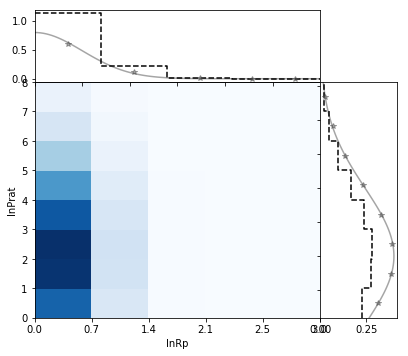

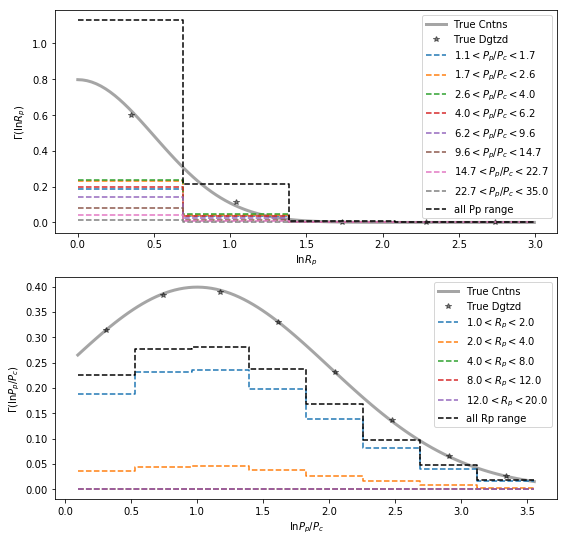

In [48]:
# plot discretized 2D gamma map (+ 1D gamma distributions)
contour_hist([mux, sigx, muy, sigy, normx, normy], x, y, xbins, ybins, 
             xlabel='lnRp', ylabel='lnPrat')

plt.figure(figsize=(9,9))
plt.subplot(211)
test = np.argsort(np.append(xbins, xbins[1:-1]))
plt.plot(x, fx, '-', lw=3, alpha=0.5, color='0.3', label='True Cntns')
plt.plot(get_bin_centers(xbins), int_fx, 'k*', alpha=0.5, label='True Dgtzd')

for ii in range(ybins.shape[0]-1):
    plt.plot( np.append(xbins, xbins[1:-1])[test],np.repeat(data[:,ii],2), '--', 
             label='{:.1f}$< P_p/P_c<${:.1f}'.format((np.exp(ybins[ii])), (np.exp(ybins[ii+1]))))

plt.plot(np.append(xbins, xbins[1:-1])[test], np.repeat(data.sum(axis=-1),2), 'k--', label='all Pp range')
plt.xlabel('$\ln R_p$')
plt.ylabel('$\Gamma (\ln R_p)$')
plt.legend()

plt.subplot(212)
test = np.argsort(np.append(ybins, ybins[1:-1]))
plt.plot(y, fy, '-', lw=3, alpha=0.5, color='0.3', label='True Cntns')
plt.plot(get_bin_centers(ybins), int_fy, 'k*', alpha=0.5, label='True Dgtzd')

for ii in range(xbins.shape[0]-1):
    plt.plot(np.append(ybins, ybins[1:-1])[test], np.repeat(data[ii,:],2), '--', 
             label='{:.1f}$<R_p<${:.1f}'.format((np.exp(xbins[ii])), (np.exp(xbins[ii+1]))))

plt.plot(np.append(ybins, ybins[1:-1])[test], np.repeat(data.sum(axis=0),2), 'k--', label='all Rp range')

plt.xlabel('$\ln P_p/P_c$')
plt.ylabel('$\Gamma (\ln P_p/P_c)$')
plt.legend()

# Now let's run MCMC and try to recover parameters, using the "noisy" 2D $\Gamma$ data map. #

### Start with fixing all parameters to true values, except (fit for) $\eta_y$ ###
Posterior distribution of $\eta_y$ centered around $\approx$1, the true value, as expected.

In [7]:
seed_p0 = [mux, sigx, muy, sigy, normx, 0.9]
labels = ['lnRp mu', 'lnRp sig', 'lnPrat mu', 'lnPrat sig', 'norm mu', 'norm sig']
ndim = len(seed_p0)
nwalkers = 128
p0 = np.random.randn(nwalkers, ndim)*seed_p0*1e-4+seed_p0
# only allow the normalization constants to vary, keep all others at true values
p0[:,:-1] = seed_p0[:-1]
#print(p0[:,0])
test_lnprob = np.zeros(nwalkers)
for ii in range(nwalkers):
    test_lnprob[ii] = lnprob_flattened(p0[ii,:], data_wn, noise, xbins, ybins, Vj)
    if not np.isfinite(test_lnprob[ii]):
        print("{} {} lnprior_lognorm {}".format(ii, p0[ii,:], test_lnprob[ii]))
print(p0.shape
start_time = time.time()
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_flattened, 
                           args=[data_wn, noise, xbins, ybins, Vj])
_ = sampler.run_mcmc(p0, 3000)
print(time.time()-start_time)
# #lnprob_flattened(alpha.ravel(), None, logRp_bins, logPp_bins, Vj, Qc, gammaprior=True)
samples = sampler.chain

(128, 6)


(array([  254.,  4196., 17429., 25671., 19336., 22398., 24794., 11822.,
         2028.,    72.]),
 array([0.99703728, 0.99768145, 0.99832562, 0.99896979, 0.99961396,
        1.00025812, 1.00090229, 1.00154646, 1.00219063, 1.0028348 ,
        1.00347896]),
 <a list of 10 Patch objects>)

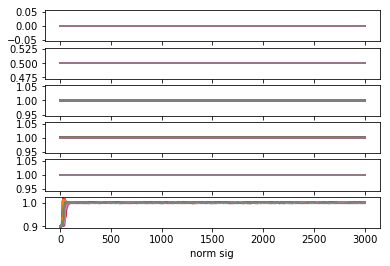

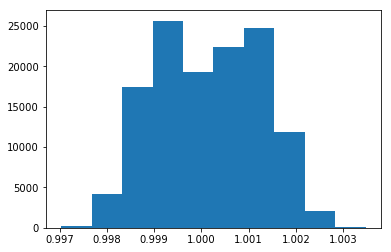

In [9]:
plt.figure()
for ii in range(ndim):
    plt.subplot(ndim,1,ii+1)
    plt.plot(samples[:,:,ii].T)
    plt.xlabel(labels[ii])
plt.figure()
plt.hist(samples[:,2000:, -1].ravel())

### Now fit for both $\eta_x, \eta_y$ ###

Even with true distributions having different $\mu$ and $\sigma$, posteriors in $\eta_x, \eta_y$ are correlated and peak at wrong values individually, and 2D-normalization $\eta_x * \eta_y$ is better constrained.

In [39]:
seed_p0 = [mux, sigx, muy, sigy, 0.9, 0.9]
ndim = len(seed_p0)
nwalkers = 128
p0 = np.random.randn(nwalkers, ndim)*seed_p0*1e-4+seed_p0
# only allow both normalization constants to vary
p0[:,:-2] = seed_p0[:-2]
niter=10000
#print(p0[:,0])
test_lnprob = np.zeros(nwalkers)
for ii in range(nwalkers):
    test_lnprob[ii] = lnprob_flattened(p0[ii,:], data_wn, noise, xbins, ybins, Vj)
    if not np.isfinite(test_lnprob[ii]):
        print("{} {} lnprior_lognorm {}".format(ii, p0[ii,:], test_lnprob[ii]))
print(p0.shape)
start_time = time.time()
sampler2 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_flattened, 
                           args=[data_wn, noise, xbins, ybins, Vj])
_ = sampler2.run_mcmc(p0, niter)
print(time.time()-start_time)
# #lnprob_flattened(alpha.ravel(), None, logRp_bins, logPp_bins, Vj, Qc, gammaprior=True)

(128, 6)
107.006716013


(array([14498., 28986., 48911., 65516., 20462., 40232., 16857., 13650.,
         4245.,  2643.]),
 array([0.56453613, 0.69861071, 0.83268529, 0.96675988, 1.10083446,
        1.23490904, 1.36898363, 1.50305821, 1.6371328 , 1.77120738,
        1.90528196]),
 <a list of 10 Patch objects>)

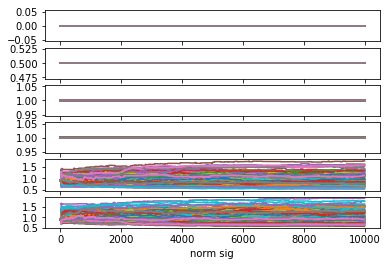

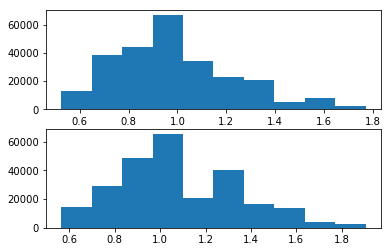

In [40]:
samples2 = sampler2.chain
labels = ['lnRp mu', 'lnRp sig', 'lnPrat mu', 'lnPrat sig', 'norm mu', 'norm sig']
plt.figure()
for ii in range(ndim):
    plt.subplot(ndim,1,ii+1)
    plt.plot(samples2[:,:,ii].T)
    plt.xlabel(labels[ii])
plt.figure()
plt.subplot(211)
plt.hist(samples2[:,niter-2000:, -2].ravel())
plt.subplot(212)
plt.hist(samples2[:,niter-2000:, -1].ravel())

### Make a 2D map of the $\Gamma$ prediction based on *one* of the posterior sample values ###. 
Again, a bit confused about the 1D histograms

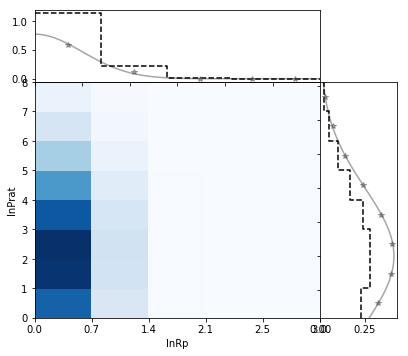

In [49]:
contour_hist([mux, sigx, muy, sigy, samples2[0,niter-2000,-2], 
                     samples2[0,niter-2000,-1]], x, y, xbins, ybins, 
             xlabel='lnRp', ylabel='lnPrat')

### Given that individual normalizations $\eta_x, \eta_y$ are not well constrained, let's now try to fit for $\eta_y$, but seed MCMC w/ wrong value for $\eta_x$. ###

Posteriors for $\eta_y$ are better constrained, and peaks at 3.333. $\eta_x \eta_y = 3.333 \times 0.3 \approx 1$, the true 2D norm value.

In [13]:
seed_p0 = [mux, sigx, muy, sigy, 0.3, 1.0]
ndim = len(seed_p0)
nwalkers = 128
p0 = np.random.randn(nwalkers, ndim)*seed_p0*1e-4+seed_p0
# only allow normy to walk, note normx is fixed at wrong value (0.3 instead of 1.0)
p0[:,:-1] = seed_p0[:-1]
niter=10000
#print(p0[:,0])
test_lnprob = np.zeros(nwalkers)
for ii in range(nwalkers):
    test_lnprob[ii] = lnprob_flattened(p0[ii,:], data_wn, noise, xbins, ybins, Vj)
    if not np.isfinite(test_lnprob[ii]):
        print("{} {} lnprior_lognorm {}".format(ii, p0[ii,:], test_lnprob[ii]))
print(p0.shape)
start_time = time.time()
sampler3 = emcee.EnsembleSampler(nwalkers, ndim, lnprob_flattened, 
                           args=[data_wn, noise, xbins, ybins, Vj])
_ = sampler3.run_mcmc(p0, niter)
print(time.time()-start_time)
# #lnprob_flattened(alpha.ravel(), None, logRp_bins, logPp_bins, Vj, Qc, gammaprior=True)

(128, 6)
105.656754017


(array([5.1000e+01, 2.0270e+03, 2.0195e+04, 5.1502e+04, 4.6697e+04,
        4.0727e+04, 5.4808e+04, 3.3329e+04, 6.3660e+03, 2.9800e+02]),
 array([3.32208513, 3.32434068, 3.32659624, 3.3288518 , 3.33110736,
        3.33336292, 3.33561848, 3.33787404, 3.3401296 , 3.34238516,
        3.34464071]),
 <a list of 10 Patch objects>)

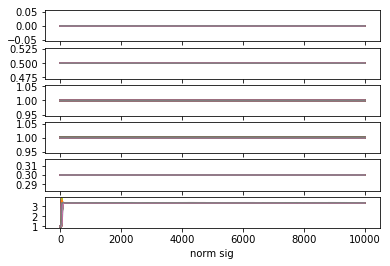

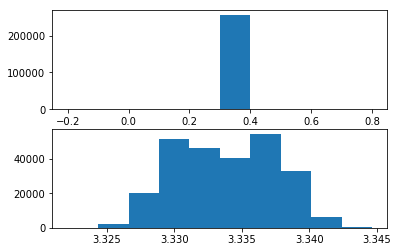

In [14]:
samples3 = sampler3.chain
labels = ['lnRp mu', 'lnRp sig', 'lnPrat mu', 'lnPrat sig', 'norm mu', 'norm sig']
plt.figure()
for ii in range(ndim):
    plt.subplot(ndim,1,ii+1)
    plt.plot(samples3[:,:,ii].T)
    plt.xlabel(labels[ii])
plt.figure()
plt.subplot(211)
plt.hist(samples3[:,niter-2000:, -2].ravel())
plt.subplot(212)
plt.hist(samples3[:,niter-2000:, -1].ravel())

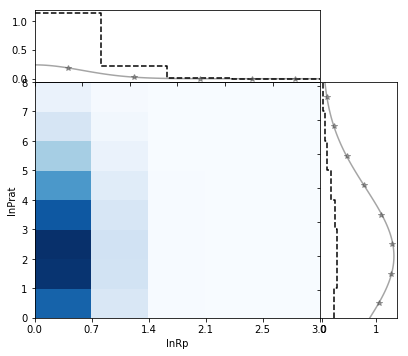

In [50]:
contour_hist([mux, sigx, muy, sigy, samples3[0,niter-2000,-2], samples3[0,niter-2000,-1]], 
             x, y, xbins, ybins,
             xlabel='lnRp', ylabel='lnPrat')

In [16]:
samples[0,2000,-2:], samples2[0,8000,-2:], samples3[0,8000,-2:]

(array([1.       , 0.9990669]),
 array([0.89815889, 1.11411687]),
 array([0.3       , 3.33477336]))